# SMQTK Docker Bundle Example Usage and Demonstration

This notebook demonstrates how to use the prepared docker containers that provide the SMQTK nearest neighbor service from within a python application.


In addition to the packages needed to run jupyter notebooks, you will also need to have the following python packages installed:

 - docker-compose
 - matplotlib
 - numpy
 - pillow
 - requests
 - backports.tempfile (if running Python 2)


In addition, you will also need:

 - the latest version of docker installed and properly configured for your host system
 - a copy of the SMQTK source code
 - and a collection of images under a single directory in your host's local filesystem

In [3]:
!python -m pip install numpy matplotlib docker-compose pillow requests backports.tempfile

## Set input variables

Only two variables need be adjusted for this demonstration; they are `path_to_smqtk_source` and `path_to_image_collection`, and you should change the code below so that they are set to the path to the SMQTK source code and the path to the directory containing the collection of images you will use as input to the nearest neighbor service, respectively.

### Optional: Download SMQTK and Leeds Butterfly Dataset
If you leave the two variables set to `None`, then the following code cell will make a temporary directory, use `git` to checkout the latest version of SMQTK within in, and fetch a copy of the Leeds Butterfly data set from data.kitware.com.

In [7]:
import os
import os.path

path_to_smqtk_source = None
path_to_image_collection = None

try: # avoid getting "stuck" in a temp dir that has since been removed
    os.chdir(last_cwd)
except NameError:
    pass

tmp_dir = None # to keep the tmp_dir from being garbage collected
if path_to_smqtk_source is None or path_to_image_collection is None:
    try:
        from tempfile import TemporaryDirectory
    except ImportError:
        from backports.tempfile import TemporaryDirectory

    import subprocess
    tmp_dir = TemporaryDirectory()
    
    if path_to_smqtk_source is None:
        path_to_smqtk_source = os.path.join(tmp_dir.name, 'SMQTK')
        print('Cloning SMQTK Repository')
        subprocess.check_call([
            'git', 'clone',
            'git://github.com/kitware/SMQTK.git',
            path_to_smqtk_source])
        print('SMQTK Repository Cloned')
        
    if path_to_image_collection is None:
        import requests
        import zipfile
        from io import BytesIO
        print('Fetching leedsbutterfly Dataset')
        req = requests.get('https://data.kitware.com/api/v1/folder/59553efa8d777f16d01e8429/download')
        zipfile = zipfile.ZipFile(BytesIO(req.content))
        zipfile.extractall(tmp_dir.name)
        path_to_image_collection = os.path.join(tmp_dir.name, 'leedsbutterfly', 'images')
        print('Dataset Fetched')
        
    print('')

last_cwd = os.getcwd()
os.chdir(os.path.join(path_to_smqtk_source, 'docker'))
print('current directory: ' + os.getcwd())
print('\nimage directory: ' +
      path_to_image_collection +
      '\n\n    contents:\n')
_, _, files = next(os.walk(path_to_image_collection))
counter = 0
for file in files:
    if file.startswith('.'):
        continue
        
    print('      ' + file)
    counter += 1
    
    if counter >= 10:
        print('\n      ...')
        break
        

Cloning SMQTK Repository
SMQTK Repository Cloned
Fetching leedsbutterfly Dataset
Dataset Fetched
current directory: /tmp/tmptva8edot/SMQTK/docker

image directory: /tmp/tmptva8edot/leedsbutterfly/images

    contents:

      002_0060.jpg
      005_0025.jpg
      004_0013.jpg
      009_0053.jpg
      010_0042.jpg
      008_0039.jpg
      009_0034.jpg
      009_0061.jpg
      003_0054.jpg
      006_0047.jpg

      ...


## The run_command() function

Here, we define a python convenience function for portably running the docker commands we will need to start and stop the nearest neighbor service.  The command is written to automatically export the `IMAGE_DIR` environment variable to the location of the image collection you specified in the prior step.  Docker will need the information in this variable to provide the data therein to the isolated containers that will run the service.

In [8]:
from sys import stdout, stderr
import subprocess as sp

subprocess_environment = os.environ.copy()
subprocess_environment['IMAGE_DIR'] = path_to_image_collection

def run_command(command):
    P = sp.Popen(command,
                 bufsize=1,
                 universal_newlines=True,
                 stdout=sp.PIPE,
                 stderr=sp.PIPE,
                 env=subprocess_environment)

    reading_stdout = True
    reading_stderr = True
    exit_code = None

    while reading_stdout or reading_stderr or exit_code is None:
        if reading_stdout:
            data = P.stdout.read(128)
            if not data:
                reading_stdout = False
            else:
                stdout.write(data)

        if reading_stderr:
            data = P.stderr.read(128)
            if not data:
                reading_stderr = False
            else:
                stderr.write(data)

        if exit_code is None:
            exit_code = P.poll()
    
    if exit_code != 0:
        raise sp.CalledProcessError()
        
    return exit_code

## Start the docker containers that will provide the nearest neighbor service

In [9]:
run_command(['docker-compose', 'up', '-d'])

Creating network "docker_default" with the default driver
Creating smqtk-postgres ... 
Creating smqtk-postgres

Creating smqtk-postgres ... done
Creating docker_smqtk_1 ... 
Creating docker_smqtk_1

Creating docker_smqtk_1 ... done
Creating docker_wrapper_1 ... 
Creating docker_wrapper_1

Creating docker_wrapper_1 ... done


0

## Wait for the service to begin accepting connections

For an initial period of time, the nearest neighbor service will be busy processing and indexing the images provided in the image collection you specified.  During this time, the service will not be accepting connections.

Below is a python loop that will poll the service until it becomes available.  Note that there is a chance that the code below may "time out", especially if your host machine is slow or if the volume of image data you provided in your collection is especially large.  In this case, you could run the code block again until it returns successfully.  You might also want to adjust the values given to `num_attempts` and `poll_interval`.

If you have trouble connecting to the service at all, check to ensure that your docker environment is operating correctly.

In [11]:
from time import sleep
import requests
from sys import stdout

num_attempts = 10
poll_interval = 30.0
connection_successful = False
for attempt in range(num_attempts):
    stdout.write('connection attempt {}/{}: '.format(attempt + 1, num_attempts))
    stdout.flush()
    req = requests.get('http://localhost:12345/count')
    if req.status_code == 503: # downstream service is still preprocessing images
        print('busy')
        sleep(poll_interval)
    else:
        print('connected!')
        connection_successful = True
        break
        
print()
if connection_successful:
    print(req.json())
else:
    print((
        'Connection failed after {} attempt{}.  '
        'Check to make sure that all docker services '
        'are running properly'
    ).format(num_attempts, '' if num_attempts == 1 else 's'))

connection attempt 1/10: connected!

{'count': 832}


## Choose a query image from the web and view it

Now, that the service is up and running, we must choose a "query" image from the web.  Change the value of `query_url` to a url that refers directly to the image you would like to use from the web (try right-clicking an image and clicking on "Copy Image Address"). 

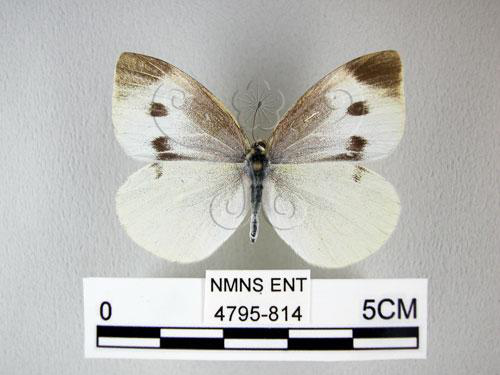

In [12]:
query_url = 'http://localhost:12345/image/b9de1f8af1093ecc1f49da847d3f1ce686f70c99'
req = requests.get(query_url)

from PIL import Image
from io import BytesIO
I = Image.open(BytesIO(req.content))
I

## Query the nearest neighbor service, proper

Now, we can use the value for `query_url` to query the nearest neighbor service and retrieve the results from that query.

In [13]:
req = requests.get('http://localhost:12345/nn/' + query_url)
result = req.json()

from pprint import pprint as pp
pp(result)

{'distances': [0.0,
               5994.130831161339,
               6696.481467936626,
               6753.814582028834,
               6959.900968690254,
               6968.659682373035,
               7035.8260701117415,
               7114.1123074948355,
               7265.294721623476,
               7402.682456576444],
 'message': 'descriptor computed',
 'neighbors': ['b9de1f8af1093ecc1f49da847d3f1ce686f70c99',
               'fa1f6c3f9c8ced3700ef3f26d496775c81c8ec40',
               'c400e7d28f752f958921fe2d500043d9686c9523',
               '54f7f92648864a74edfb6da6ba30704f166dc2df',
               '795ab5761ed1d5c7d9def9dc2cdc39d0f580bd22',
               '0526cc0ef3d987a955a8a67a0754ca1371c65e69',
               'ee3f8b878aa9b3788e89fbc9db85e86eb1d462ae',
               '22e03c9eef0b5cbd94ec22a56874490ac4918a44',
               '51e7e4c169e380aedff69f4ef10fff435ff584d8',
               '8aac399598f6b5f9ad633ba2b5bba9afeffd7e17'],
 'reference_uri': 'http://wrapper:12345/image

## Access the query results and view the neighboring images

The two most important attributes in the provided JSON response are 'distances', which quantifies how similar that particular neighbor is to your query image; and 'neighbors', which provide references to the actual neighbor images, themselves.  The code below uses numpy and matplotlib to plot the neighboring images in order of greatest similarity.

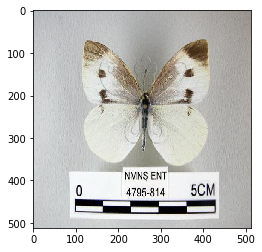

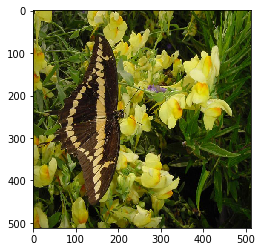

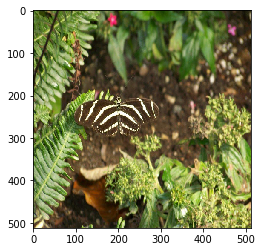

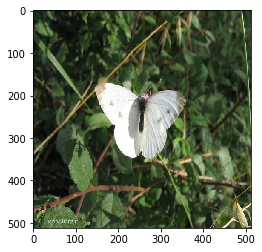

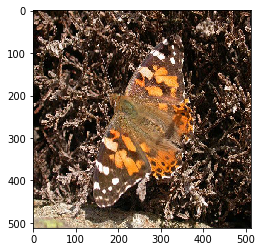

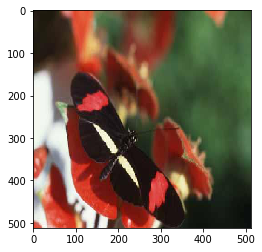

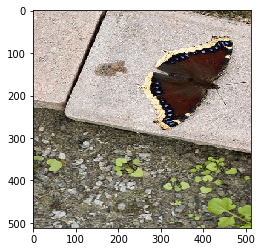

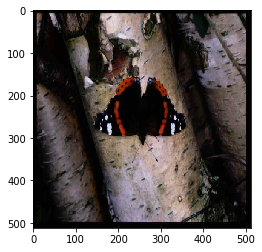

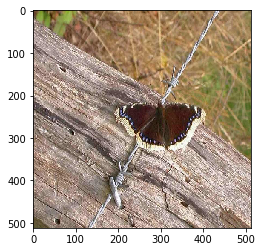

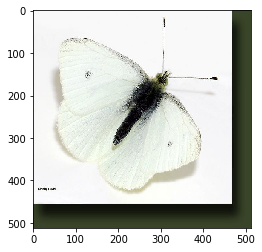

In [14]:
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import imshow

figs = []

for index, neighbor in enumerate(result['neighbors']):
    req = requests.get('http://localhost:12345/image/' + neighbor)
    I = Image.open(BytesIO(req.content))
    fig = pyplot.figure()
    fig.gca().imshow(np.asarray(I.resize((512, 512))))
    figs.append(fig)
    
pyplot.show(figs)
for fig in figs:
    fig.clear()
del figs
    

## Terminate the docker containers running the nearest-neighbor service

With a query successfully performed and visualized, this demonstration is concluded.  Make sure that you shutdown and/or terminate the docker containers from above as part of your application's clean up stage.

In [15]:
run_command(['docker-compose', 'down'])

Stopping docker_wrapper_1 ... 
Stopping docker_smqtk_1 ... 
Stopping smqtk-postgres ... 

Stopping docker_wrapper_1 ... done

Stopping docker_smqtk_1 ... done

Stopping smqtk-postgres ... done
Removing docker_wrapper_1 ... 
Removing docker_smqtk_1 ... 
Removing smqtk-postgres ... 

Removing smqtk-postgres ... done

Removing docker_smqtk_1 ... done

Removing docker_wrapper_1 ... done
Removing network docker_default


0